<a href="https://colab.research.google.com/github/VinylBr/Supervised_learning_from_scratch/blob/main/LinearRegression_Classification_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Author: Vinay Barnabas


**Note**: Functions to generate data matrix and target vector are presented sepearately. While those required to perform linear regression and logistic regression are collated within a class definition.


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm #to track progress bar
import warnings
warnings.filterwarnings("ignore")

# Regression

## Generating an input data matrix X of size NxD for regression.
Input data size $N×M$ <br>
Generator matrix size $M×D$ <br>
Input data matrix size = $[N×M]$ × $[M×D]$ gives matrix of size $N×D$ <br>
Generator matrix allows one to introduce correlations in the input data matrix

In [3]:
def gen_data_matrix(N, gen_mat, random_seed): #generating data matrix
  #N: number of samples
  #gen_mat: generator G
  #random_seed: to ensure reproducibility
  np.random.seed(random_seed) #Allows fixing the random_see: Essential for reproducibility
  M, D = len(gen_mat), len(gen_mat[0]) #extracting row and column size [1]
  feature_matrix = np.random.standard_normal(size=(N,M)) #Standard normal vectors
  return np.matmul(feature_matrix,gen_mat) #matrix multiplication [2]

### Testing the function output <br>
**Test 1 : Data matrix with independent features** <br>
Consider Generator matrix ($[M×D]$) to be identity, where $D$=$M$


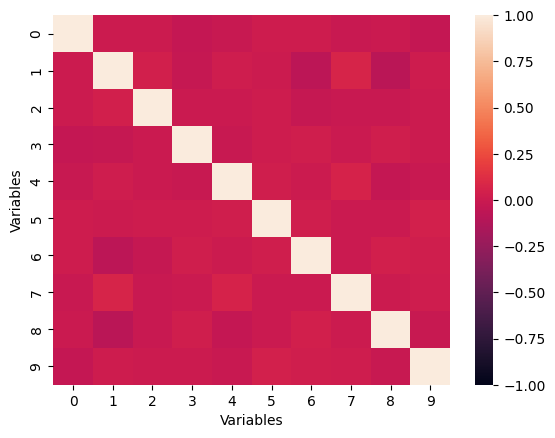

In [4]:
samples_N = 1000 #fixing the sample size
phi_D = 10 #size of extracted features
M = 10 #size of baseline features
gen_mat = np.eye(M,phi_D) #generator matrix
X = gen_data_matrix(samples_N,gen_mat, random_seed = 10) #generate data matrix
X_df = pd.DataFrame(X) #recasting the matrix as a dataframe to be used in seaborn package
uncorrMatrix = X_df.corr() # generating the correlation matrix
sns.heatmap(uncorrMatrix, annot=False, vmin = -1, vmax = 1) #plotting correlating matrix in seaborn
plt.xlabel("Variables") #defining the x-axis label
plt.ylabel("Variables") #defining the y-axis label
plt.show() #show the plot

**Observation**: <br>
There is no correlation among the columns of X <br>
Diagonals are, expectedly, correlated <br>

**Next Step**: <br>
We introduce correlations in the matrix

**Test 2 : Introducing Correlations in the columns of data matrix** <br>
Considering generator matrix ($[M×D]$) to be a symmetrix correlation matrix, such that <br> $x(i,j)=x(j,i)$, where $i$ is not equal to $j$



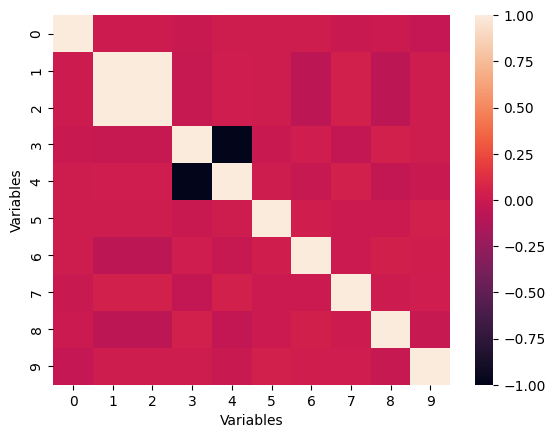

In [5]:
samples_N = 1000 #fixing the sample size
phi_D = 10 #number of extracted features
M = 10 #number of original features
gen_mat = np.eye(M,phi_D) #generator matrix
gen_mat[2,1], gen_mat[1,2] = 1, 1 #generating a symmetric correlation matrix
gen_mat[3,4], gen_mat[4,3] = -1, -1 #introducing negative correlations
X_corr = gen_data_matrix(samples_N,gen_mat, random_seed = 10) #generating the data matrix
X_corr_df = pd.DataFrame(X_corr) #recasting the matrix as a dataframe to be used in seaborn
corrMatrix = X_corr_df.corr() #generating the correlation matrix
sns.heatmap(corrMatrix, annot=False) #plotting the correlation matrix using seaborn.
plt.xlabel("Variables") #defining the x-axis label
plt.ylabel("Variables") #defining the y-axis label
plt.show() #show the plot

**Observation**: <br>
Variables 1 and 2 are positively correlated <br>
Variables 3 and 4 are negatively correlated <br>
**Next Step**: <br>
Problem 3

## A function to generate the target vector t of size $N\times 1$: <br>
Appended a column of $1s$ for bias $b$ to data matrix ($[N\times D]$ <br>
To generate target vector ($[N\times1]$), multiply $X$ of size $[N\times(D+1)]$ with weight vector of size $[(D+1)×1]$ <br>


In [6]:
def gen_target(X, w, variance): #generate the target vector
  #X: data matrix
  #w: weight vector
  #variance: variance controls the noise
  if len(X[0]) == len(w)-1: #Checking if column length of X matches row size of W without bias
    mean = 0 #setting the mean noise to 0
    noise = np.random.normal(mean, np.sqrt(variance), (len(X),1)) # adding noise with mean = 0 and standard deviation sqrt(variance)
    #return noise
    return np.matmul(X,w[1:]) + w[0] + noise # return W^Tx + b + noise

  else:
    print("Mismatched size: Col of X and Row of w")

## Defining the class myLinearRegression
An instance of the class has the following methods (Explanations provided following class definition)
1. calculate analytical solution for linear regression
2. train_test_split
3. calculate normalized RMSE
4. gradient descent (fit)
5. predict the output
6. calculate gradient with L1 and L2 regularization

In [51]:
class myLinearRegression: #class for Linear Regression [3][4]
  def __init__(self, learning_rate = 0.05, max_iterations = 100000, verbose = True):
    self.learning_rate = learning_rate #fixing learning rate
    self.max_iterations = max_iterations #fixing max_iterations
    self.verbose = verbose
    #self.tolerance = tolerance

  @staticmethod
  def cal_analytic_w(X, target): #To calculate w using the analytic expression
    #input: X = data matrix
    #input: target = target vector
    X_with1 = np.column_stack((np.ones(np.size(target)),X)) #adding ones in the first column. X (N x D) -> X_with1 (N x D+1) allowing us to combine bias and weights. Inspiration: https://stackoverflow.com/questions/32827269/adding-columns-to-matrix-in-python
    return np.linalg.multi_dot([np.linalg.pinv(np.matmul(X_with1.T,X_with1)),X_with1.T,target]) # [5]

  @staticmethod
  def train_test_split(dataset, target, percent_train, random_seed): #static method of splitting the data
  #dataset = datamatrix to be split
  #target = target vector to be split
  #percent_train = fraction of data to be used for training
  #random_seed

      np.random.seed(random_seed) #setting random seed to ensure reproducibility, inspiration from [6]
      index = np.arange(len(target)) #index of each sample is created
      np.random.shuffle(index) #index is shuffled
      train = dict() #creating a dictionary for train
      test = dict() #dictionary for test data. inspiration [7]
      X_shuffle = dataset[index] #datamatrix is shuffled
      target_shuffle = target[index] #according targetmatrix is shuffled

      rows_interest = int(percent_train*np.size(target))#extracting rows of interest [8]

      train['X'], test['X'] = np.split(X_shuffle,[rows_interest])#assigning train and test data for X. Use of split [9]
      train['target'], test['target'] = np.split(target_shuffle,[rows_interest])# assigning train and test data for target
      return train, test #return the dictionary of test and train

  #Question 4
  @staticmethod
  def cal_NRMSE(ref, vec): #static method of calculating Normalized RMSE
    #ref: target vector
    #vec: vector to be compared
    return np.sqrt(np.matmul((ref-vec).T, (ref-vec))/(len(vec)*np.var(ref))) #transpose(t - vec) * (t - vec)/N and the quantity normalized by variance of t

  #Question 8
  def fit(self, X, target, L1, L2): #calculating gradient descent
    #X: datamatrix
    #target: target vector
    #L1: L1 regularization parameter
    #L2: L2 regularization parameter

    self.X = X #X is stored as a class variable to be used inside the class
    self.target = target #target is stored as a class variable to be used inside the class
    self.L1 = L1 #L1 stored as a class variable to be used inside the class
    self.L2 = L2 #L2 stored as a class variable to be used inside the class
    w_old = np.random.random((len(X[0])+1,1)) #starting with a random value for weights
    #count = 0 #initializing the count
    counter = tqdm(range(self.max_iterations), desc = "Grad-Descent") if self.verbose else range(self.max_iterations) #print progressbar based on verbose
    for count in counter:
      w_new = w_old - self.learning_rate*self.cal_gradient_L1L2(w_old) #updating weights
      w_old = w_new # preparing for the next loop

    #while count < self.max_iterations: #loop until max_iterations are reached
    #  w_new = w_old - self.learning_rate*self.cal_gradient_L1L2(w_old) #updating weights
    #  w_old = w_new # preparing for the next loop
    #  count+=1 #increment count
    self.w = w_old #estimate weight is stored as a class variable to be used inside the class

  def predict_y(self, X): #function to predict y_i
    #X: data matrix
    X_with1 = np.column_stack((np.ones(len(X)),X)) #adding ones in the first column. X (N x D) -> X_with1 (N x D+1) allowing us to combine bias and weights #https://stackoverflow.com/questions/32827269/adding-columns-to-matrix-in-python
    #Add a check to ensure w_pred is a column
    return np.matmul(X_with1,self.w) #return W^T*X + b


  #Question 5, 6, and 7
  def cal_gradient_L1L2(self, w_input): #calculating gradient of mean squared error
    #w_input: weights
    #self.X: data matrix
    #self.target: target vector
    X_with1 = np.column_stack((np.ones(len(self.X)),self.X)) #adding ones in the first column. X (N x D) -> X_with1 (N x D+1) allowing us to combine bias and weights #https://stackoverflow.com/questions/32827269/adding-columns-to-matrix-in-python
    y_input = np.matmul(X_with1,w_input) #calculate y for w_input

    if self.L1 !=0 : #check if L1 is non-zero
      L1_term = self.L1*np.vstack([[0],np.sign(w_input[1:])]) #bias term excluded, sign vector of size Dx1
    else:
      L1_term = 0 #unregularized

    if self.L2 !=0 :
      L2_term =  self.L2*np.vstack([[0],w_input[1:]]) #bias term excluded, weight vector of size Dx1
    else:
      L2_term = 0 #unregularized

    return -(1/len(self.target))*np.matmul(X_with1.T, (self.target-y_input)) + L1_term + L2_term # -(1/N)*(transpose(X) * (t - y)), inspiration [6]




**Analytic solution for weights in linear regression** <br>
$w$ = $(X^T × X)^{-1}$ × ($X^T \times T$) <br>
we get the pseudoinverse of $(X^T \times X)$ since their inverse may not be defined owing to correlations among features in large data matrices

In [52]:
def cal_analytic_w(X, target): #To calculate w using the analytic expression
    #input: X = data matrix
    #input: target = target vector
    X_with1 = np.column_stack((np.ones(np.size(target)),X)) #adding ones in the first column. X (N x D) -> X_with1 (N x D+1) allowing us to combine bias and weights. Inspiration: https://stackoverflow.com/questions/32827269/adding-columns-to-matrix-in-python
    return np.linalg.multi_dot([np.linalg.pinv(np.matmul(X_with1.T,X_with1)),X_with1.T,target]) # [5]


**Normalized mean squared error (NRMSE)** <br>
$$NRMSE = \frac{\sqrt{   \frac{∑_i^N (y_{true} - y_{prediction})^2}{N}   }}{σ}$$ <br>

Vectorized implementation:<br>

$$NRMSE = \sqrt{\frac{(y_{true} - y_{prediction})^T\times(y_{true} - y_{prediction})}{(N\timesσ^2)}}$$ <br>




In [53]:
def cal_NRMSE(ref, vec): #static method of calculating Normalized RMSE
    #ref: target vector
    #vec: vector to be compared
    return np.sqrt(np.matmul((ref-vec).T, (ref-vec))/(len(vec)*np.var(ref))) #transpose(t - vec) * (t - vec)/N and the quantity normalized by variance of t


**Y prediction** <br>
$y_{prediction} = X\times w$ <br> with X of size $[N\times(D+1)]$ and $w$ of size $[(D+1)\times1]$

In [54]:
  def predict_y(self, X): #function to predict y_i
    #X: data matrix
    X_with1 = np.column_stack((np.ones(len(X)),X)) #adding ones in the first column. X (N x D) -> X_with1 (N x D+1) allowing us to combine bias and weights #https://stackoverflow.com/questions/32827269/adding-columns-to-matrix-in-python
    #Add a check to ensure w_pred is a column
    return np.matmul(X_with1,self.w) #return W^T*X + b

**Gradient Descent Algorithm**
⇒Taking a step in the opposite direction of the gradient <br>
$$w_{i+1} = w_i - α \times ∇F$$ <br>
$\alpha$ is the learning rate
- For convex functions you always arrive at the global minima
- For non-convex functions (as in Neural Networks), initial starting points for gradient descent matter

In [55]:
def fit(self, X, target, L1, L2): #calculating gradient descent
    #X: datamatrix
    #target: target vector
    #L1: L1 regularization parameter
    #L2: L2 regularization parameter

    self.X = X #X is stored as a class variable to be used inside the class
    self.target = target #target is stored as a class variable to be used inside the class
    self.L1 = L1 #L1 stored as a class variable to be used inside the class
    self.L2 = L2 #L2 stored as a class variable to be used inside the class
    w_old = np.random.random((len(X[0])+1,1)) #starting with a random value for weights
    count = 0 #initializing the count
    while count < self.max_iterations: #loop until max_iterations are reached
      w_new = w_old - self.learning_rate*self.cal_gradient_L1L2(w_old) #updating weights
      w_old = w_new # preparing for the next loop
      count+=1 #increment count
    self.w = w_old #estimate weight is stored as a class variable to be used inside the class


**Calculating Gradient** <br>
 $$Loss Function (MSE): =  \frac{(y_{true} - y_{prediction})^T(y_{true} - y_{prediction})}{2\times N} + \lambda_2\times \frac{w^T\times w}{2} + \lambda_1|w|  $$
 $$\nabla_w Loss: = - \frac{X^T \times (y_{true} - y_{prediction})}{N}  + \lambda_2 \times w + \lambda_1\times sign(w)$$ <br>
 where $y_{prediction} = X \times w$ <br>
$\lambda_2$ = L2 regularization parameter <br>
$\lambda_1$ = L1 regularization parameter



In [56]:
  def cal_gradient_L1L2(self, w_input): #calculating gradient of mean squared error
    #w_input: weights
    #self.X: data matrix
    #self.target: target vector
    X_with1 = np.column_stack((np.ones(len(self.X)),self.X)) #adding ones in the first column. X (N x D) -> X_with1 (N x D+1) allowing us to combine bias and weights #https://stackoverflow.com/questions/32827269/adding-columns-to-matrix-in-python
    y_input = np.matmul(X_with1,w_input) #calculate y for w_input

    if self.L1 !=0 : #check if L1 is non-zero
      L1_term = self.L1*np.vstack([[0],np.sign(w_input[1:])]) #bias term excluded, sign vector of size Dx1
    else:
      L1_term = 0 #unregularized

    if self.L2 !=0 :
      L2_term =  self.L2*np.vstack([[0],w_input[1:]]) #bias term excluded, weight vector of size Dx1
    else:
      L2_term = 0 #unregularized

    return -(1/len(self.target))*np.matmul(X_with1.T, (self.target-y_input)) + L1_term + L2_term # -(1/N)*(transpose(X) * (t - y)), inspiration [6]



## Examining the behavior of the analytical solver based on pseudo-inverse (pinv) in numpy.linalg package with respect to the size of the data matrix.

In [ ]:
D_trials = 10 #Column size of extracted feature matrix
M_trials = 10 #Row size of of basal feature matrix
gen_mat_trials = np.eye(M_trials,D_trials) #Generative matrix G. Identity ensures no correlation between the features
N_min, N_max = 1, 7 #setting the range of sample size
num_trials = 50 #number trials in the range of sample size
N_trials = np.round(np.logspace(N_min, N_max, num = num_trials).astype(int),0) #to prevent float values causing errors in np.random
variance_trials = 1 #variance of target matrix
w_trials = np.ones((D_trials+1,1)) #Fixing the weights to generate a target vector
time_trials = [] #only when it is empty I can use append
random_seed = 10
for count,N_try in enumerate(N_trials): #for loop with enumerate to get items (ex: N_try) nad the iteration count (ex: count), [12]
  X_trials = gen_data_matrix(N_try,gen_mat_trials,random_seed) #generate data matrix of size N_try x D_trials
  t_trials = gen_target(X_trials, w_trials, variance_trials) #generate target vector of size N_try x 1

  start_time = time.time() #starts the timer
  w_pred = myLinearRegression.cal_analytic_w(X_trials,t_trials) #calculate weights using analytical expression
  end_time = time.time() #ends the timer
  time_trials.append(end_time-start_time) #append the difference in time (s)



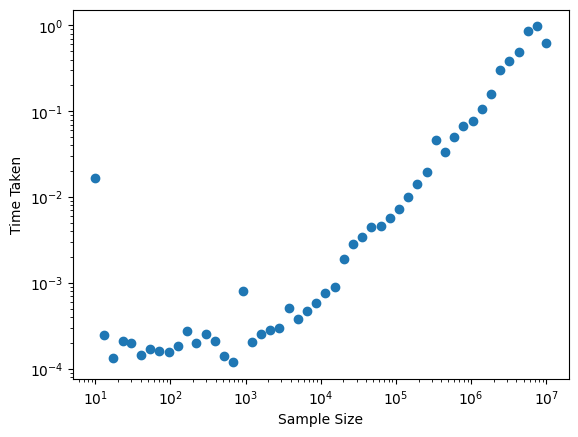

In [ ]:
plt.loglog(N_trials, time_trials,'o') #plot x- and y-axis on log scale
plt.xlabel("Sample Size") #define x-axis label
plt.ylabel("Time Taken (s)") #define y-axis label
plt.show() #show the plot

**Observation**: <br>
Time taken increases for sample sizes greater than 100 <br>
For sample_size = 10^8 the session crashes after using all available RAM. <br> For a system with greater RAM this threshold might be at higher samples sizes


**Next Step**: <br>
I was interested in checking how does the threshold on sample_size vary with correlated features in the datamatrix. <br>
So I introduce correlations in feature 1 and 3 and repeat the above exercise

In [ ]:
D_trials = 10 #Column size of extracted feature matrix
M_trials = 10 #Row size of of basal feature matrix
gen_mat_corr = np.eye(M_trials,D_trials) #Generative matrix G. Identity ensures no correlation between the features
gen_mat_corr[:,3] = 3*gen_mat_corr[:,1] #Creating correlations
N_min, N_max = 1, 7 #setting the range of sample size
num_trials = 50 #number trials in the range of sample size
N_trials = np.round(np.logspace(N_min, N_max, num = num_trials).astype(int),0) #to prevent float values causing errors in np.random
variance_trials = 1 #variance of target matrix
w_trials = np.ones((D_trials+1,1)) #Fixing the weights to generate a target vector
time_trials_corr = [] #only when it is empty I can use append
random_seed = 10 #fixing the random_seed
for count,N_try in enumerate(N_trials): #for loop with enumerate to get items (ex: N_try) nad the iteration count (ex: count), [12]
  X_corr = gen_data_matrix(N_try,gen_mat_corr,random_seed) #generate data matrix of size N_try x D_trials
  t_trials = gen_target(X_corr, w_trials, variance_trials) #generate target vector of size N_try x 1

  start_time = time.time() #starts the timer
  w_pred = myLinearRegression.cal_analytic_w(X_corr,t_trials) #cal_analytic_w is a static method and hence does not require an instance of the class
  end_time = time.time() #ends the timer
  time_trials_corr.append(end_time-start_time) #save the difference in time (s)


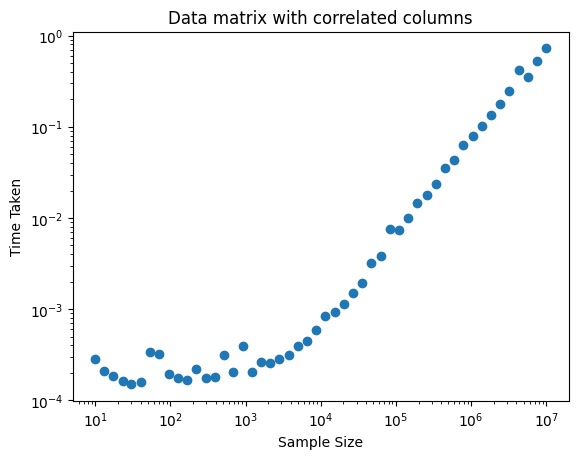

In [ ]:
plt.loglog(N_trials, time_trials_corr,'o') #plot number of trials vs the time taken, both in log scale
plt.xlabel("Sample Size") #define the x-axis label
plt.ylabel("Time Taken (s)") #define the y-axis label
plt.title("Data matrix with correlated columns") #define the title
plt.show() #show the plot

**Observation**: <br>
There was not significant difference in the time taken for execution even with <br> correlated columns

**Next Step**: <br>
Testing the implementation of Linear Regression

[## Functions that calculate gradient (Not used in the code, presented for review)
The following functions are presented separately for the sake of the reviewer. In the code, these functions are used within the class definition of myLinearRegression() and myLogRegression():

## Gradient descent on MSE + λ1 L1 + λ2 L2 for linear regression using an appropriate stopping criterion.

In [46]:
samples_N = 1000 #Fixing number of samples
val_D = 1 # Considering 1-D data
M = 20 # number of baseline features
gen_mat = np.eye(M,val_D) #generator matrix
X = gen_data_matrix(samples_N,gen_mat, random_seed = 10) #generating the data matrix
w = [[2], [5]] # using b = 2 and w = 5
variance = 1 # setting variance to 1
t = gen_target(X, w, variance) #generating target variable
linreg = myLinearRegression() #creating an instance of myLinearRegression class
linreg.fit(X,t, L1=0, L2=0) #generating a fit
y_predict = linreg.predict_y(X) #obtaining a prediction


Grad-Descent:   0%|          | 0/100000 [00:00<?, ?it/s]

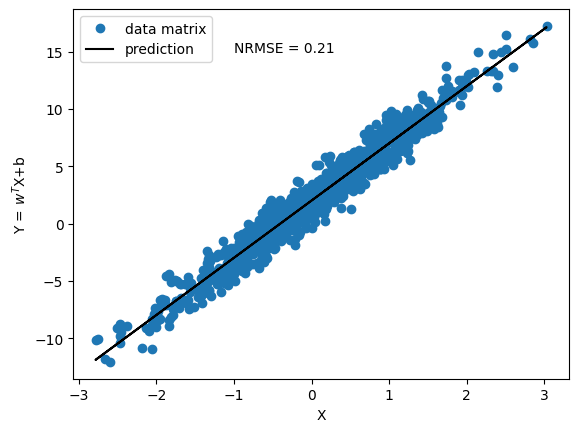

In [47]:
plt.plot(X, t,'o',label = "data matrix") #plotting the experimental data
plt.plot(X, y_predict, label = "prediction", c = "black") #plotting the predicted line
plt.xlabel("X")  #setting x-axis label
plt.ylabel("Y = $w^T$X+b") #setting y-axis label
plt.text(-1,15,"NRMSE = {:.2f}".format(linreg.cal_NRMSE(t,y_predict)[0,0])) #adding NRMSE
plt.legend() #show the legend
plt.show() #show the plot

**Observation**: <br>
Here, experimental data is spread around the mean with variance = 1 <br>
We see that the predicted line captures the linear relationship of the data <br> with a normalized RMSE of 0.2

**Next Step**: <br>
Instead of arbitrary choosing maximum iterations and learning rate, <br> I vary them in a range and compure the NRMSE for each pair. This will ensure <br> that I am not wasting time by setting a very high value for maximum iterations

In [49]:
samples_N = 1000 #setting sample size
val_D = 1 #using 1-d data
M = 20 #number of baseline featrues
gen_mat = np.eye(M,val_D) #generator identity matrix
X = gen_data_matrix(samples_N,gen_mat, random_seed = 10) #generate the data matrix
w = [[2], [5]] #fixing the b = 2 and w = 5
variance = 1 #setting the variance to 1
t = gen_target(X, w, variance) #generating the target vector
num_learning, num_iter = 5, 5 #fixing number of points to test for learning_rate and max_iterations
learning_rate_vector = np.logspace(-2, 0, num = num_learning) #range of learning_rate [0.01 1]
iterations_vector = np.logspace(1, 6, num = num_iter) #range of maximum iterations [10 1000000]
error_iter_learning = np.empty((num_learning, num_iter)) #initializing the error_vector
for l in np.arange(num_learning): #counter for learning_rate
  for i in np.arange(num_iter): #counter for num_iterations
    linreg = myLinearRegression(learning_rate = learning_rate_vector[l], max_iterations = np.floor(iterations_vector[i]).astype(int)) # create an instance of myLinearRegression
    linreg.fit(X,t, L1=0, L2=0) #estimate coefficients
    y_predict = linreg.predict_y(X) #predict y
    error_iter_learning[l,i] = linreg.cal_NRMSE(t,y_predict) #calculate error

Grad-Descent:   0%|          | 0/10 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/177 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/3162 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/56234 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/1000000 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/10 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/177 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/3162 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/56234 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/1000000 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/10 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/177 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/3162 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/56234 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/1000000 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/10 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/177 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/3162 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/56234 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/1000000 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/10 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/177 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/3162 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/56234 [00:00<?, ?it/s]

Grad-Descent:   0%|          | 0/1000000 [00:00<?, ?it/s]

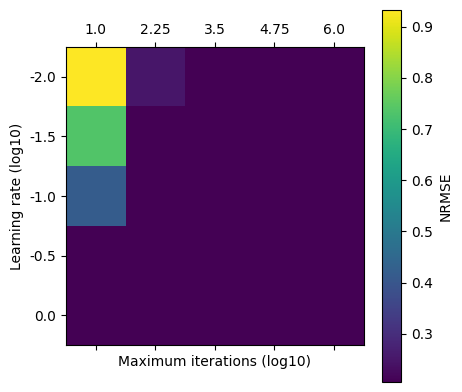

In [50]:
plt.matshow(error_iter_learning) #plot heatmap of error_iter_learning
plt.xticks(ticks = np.arange(num_iter), labels = np.log10(iterations_vector)) #modify xticks
plt.yticks(ticks = np.arange(num_learning), labels = np.log10(learning_rate_vector)) #modify yticks
plt.xlabel("Maximum iterations (log10)") #define x-axis label
plt.ylabel("Learning rate (log10)") #define y-axis label
plt.colorbar(label = "NRMSE") #show the color bar with label
plt.show() #show the plot


**Observation**: <br>
1. Max_iterations greater than ~10^3 did not improve fit <br>
However, since subsequent models would have more than one features with regularization, we <br> set the max_iterations to 10^5 <br>

2. For very small step size and small max_iterations, normalized RMSE was high. <br> For subsequent analysis we set the step size to be 0.05 <br>


**Next Step**: <br>
We examine the impact of variance on NRMSE


## Examining the impact of σ on the NRMSE for linear regression using gradient descent

In [64]:
num_trials, num_runs = 10, 5 #number of sigma that were tested, number of runs per value of sigma
variance_vector = np.logspace(-2,3, num = num_trials) #10^-2 to 10^2
val_M = 10 #number of basal features
val_D = 5 #number of extracted features
val_N = 1000 #number of samples
gen_mat = np.eye(val_M,val_D) #identity generator matrix
error_avg = [] #initializing error vector
error_std = [] #initializing std of error vector
linreg_Q9 = myLinearRegression(verbose = False) # creating an instance of myLinearRegression
for variance_index in tqdm(np.arange(num_trials), desc = "Iterations on variance"): #counter for variance_vector
  error = [] #initiatlizing error
  for runs in tqdm(np.arange(num_runs), desc = "Experiments on each iteration"): #counter for number of experiment runs
    random_seed = np.random.randint(0,10) #setting a random_seed. This is also randomized to ensure "runs" experiments have different results

    X = gen_data_matrix(val_N,gen_mat, random_seed) #generator matrix (N x D)
    variance = variance_vector[variance_index] #fixing the variance
    w = np.ones((val_D+1,1)) # original w set to 1's
    t = gen_target(X, w, variance) # generating the target vector with variance

    train_fraction = 0.8 #fixing a fraction of 80% training data
    train, test = linreg_Q9.train_test_split(X, t, train_fraction, random_seed) #Splitting into training and test data

    linreg_Q9.fit(train['X'], train['target'], L1 = 0, L2 = 0) #fitting with Training data. Unregularized
    y_validation = linreg_Q9.predict_y(test['X']) #Testing on validation data
    error.append(linreg_Q9.cal_NRMSE(test['target'], y_validation)) #calculating normalized RMSE for test data
  error_avg.append(np.mean(error)) #append mean of NRMSE
  error_std.append(np.std(error)) #append std of NRMSE

Iterations on variance:   0%|          | 0/10 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

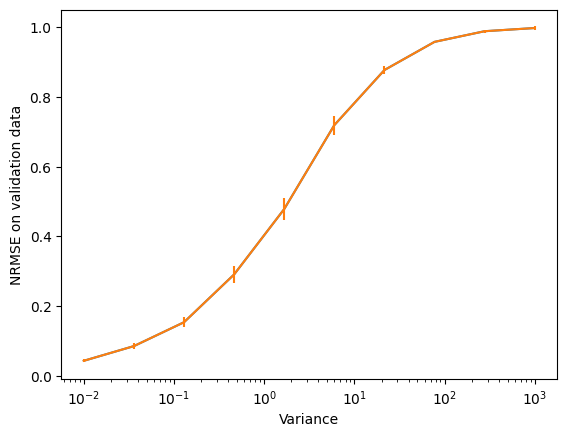

In [65]:
plt.semilogx(variance_vector, error_avg) #plot variance_vector (log-scale) against average error
plt.errorbar(variance_vector, error_avg, yerr = error_std) #plot the standard deviation
plt.xlabel('Variance') #define label for x-axis
plt.ylabel('NRMSE on validation data') #define the label for y-axis
plt.show() #show the plot

**Observation**: <br>
1. For small values of variance NRMSE is small, implying that the model is <br> able to capture the data <br>
2. For large values of variance NRMSE saturates to 1, this is because the <br> data is no longer linear and hence the linear model performs poorly <br>

**Next Step**: <br>
to examine the impact of N and lmb2 on NRMSE



## Examining the impact of N and lmb2 on Normalized RMSE


In [66]:

num_N, num_lmb2, runs = 10,10,5 #number of samples sizes, number of L2 parameters, number of runs for each pair of N and L2
N_vector = np.logspace(1,3, num = num_N) #vector of samples size in the range [10 to 1000]
lmb2_vector = np.logspace(-3,1, num = num_lmb2) #vector of L2 parameter in the range [0.001 1]

val_M = 5 #number of original features
val_D = 5 #number of extracted features
gen_mat = np.eye(val_M,val_D) #generative matrix
variance = 0.5 #variance for target vector
error_N_lmb2_test = np.empty((num_N,num_lmb2)) #initializing error in the test data
error_N_lmb2_train = np.empty((num_N,num_lmb2)) #initializing error in the training data
linreg_Q10 = myLinearRegression(verbose = False) #creating an instance of myLinearRegression class

for N_index in tqdm(np.arange(num_N), desc = "Iter on sample size"): #counter for samples sizes
  for l_index in tqdm(np.arange(num_lmb2), desc = "Iter on L2 regularization"): #counter for L2 regularization parameter
    error_test = [] #initializing test error
    error_train = [] #initiatlizing train error
    for r in np.arange(runs): #counter for number of experiments
      random_seed = np.random.randint(0,10) #setting a random seed
      val_N = int(N_vector[N_index]) #fixing the sample size

      X = gen_data_matrix(val_N,gen_mat, random_seed) #generating the data matrix

      w = np.arange(val_D+1).reshape(-1,1) #fixing the weights
      t = gen_target(X, w, variance) #generating the target vector

      train_fraction = 0.8 #fraction of training data
      train, test = linreg_Q10.train_test_split(X, t, train_fraction, random_seed) #Split into training and test data

      linreg_Q10.fit(train['X'], train['target'], L1=0, L2=lmb2_vector[l_index]) #Training with test data

      y_test = linreg_Q10.predict_y(test['X']) #predict y for test data
      y_train = linreg_Q10.predict_y(train['X']) #predict y for train data
      error_test.append(linreg_Q10.cal_NRMSE(test['target'], y_test)) #append test error
      error_train.append(linreg_Q10.cal_NRMSE(train['target'], y_train)) #append train error
      #print("N index = {}, L2 index = {}, r val = {}".format(N_index,l_index,r)) #print N_index, L2_index, and r_index
    error_N_lmb2_test[N_index,l_index] = np.mean(error_test) #calculate the mean across the experiments
    error_N_lmb2_train[N_index,l_index] = np.mean(error_train) #calculate the mean acorss the experiments


Iter on sample size:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2 regularization:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2 regularization:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2 regularization:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2 regularization:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2 regularization:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2 regularization:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2 regularization:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2 regularization:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2 regularization:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2 regularization:   0%|          | 0/10 [00:00<?, ?it/s]

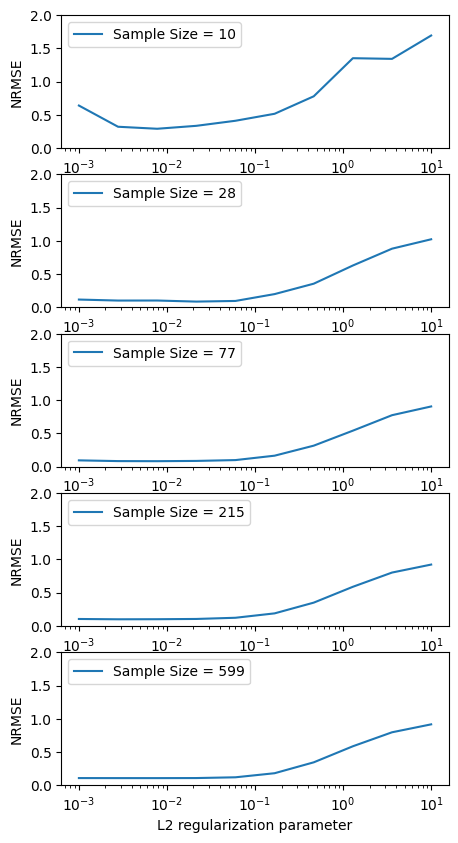

In [67]:
fig, ax = plt.subplots(5,1, figsize = (5,10)) #defining subplot axes and fig
for count, p in enumerate(np.arange(0,num_N, step=2)): # counter on number of samples
  ax[count].semilogx(lmb2_vector, error_N_lmb2_test[p], label = "Sample Size = {:.0f}".format(N_vector[p])) #plot L2 vs test error
  ax[count].legend(loc = "upper left") # show the legend
  ax[count].set_ylim(0,2) #set y-axis limits
  ax[count].set_ylabel("NRMSE") #define y-axis label
plt.xlabel("L2 regularization parameter") #define x-axis label
plt.show() #show the plot

**Observation**: <br>
For small sample size, we see a minima of test error with increasing L2 parameter <br> This is because at low sample size, when L2 is small, we have overfitting of training data leading to higher test errors. However, when L2 is large, there is underfitting of training data leading to higher test errors. <br> That gives us the sweet spot for minima of L2 where there is neither underfitting nor overfitting. <br>

**Next Step**: <br>
I plot test errors and train errors with increasing sample sizes

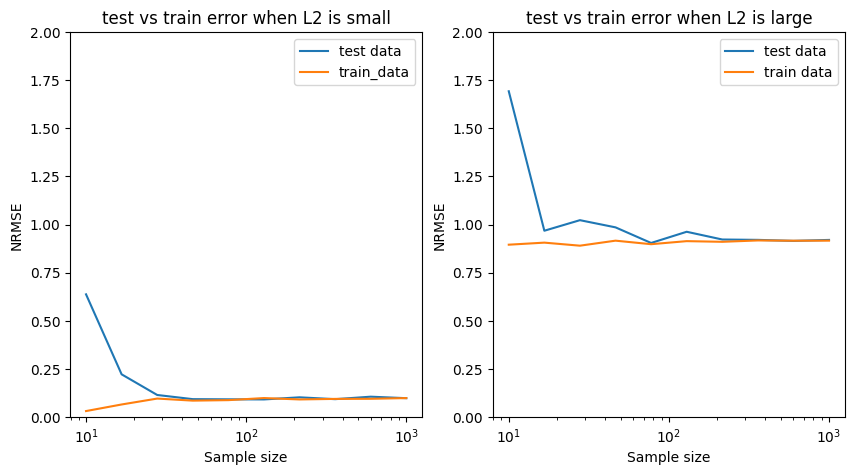

In [68]:
fig, ax = plt.subplots(1,2, figsize = (10,5)) #create subplots with two columns

ax[0].semilogx(N_vector, error_N_lmb2_test[:,0], label = "test data") #plot test errors
ax[0].semilogx(N_vector, error_N_lmb2_train[:,0], label = "train_data") #plot train errors
ax[0].set_ylim(0, 2) #set y-axis limits
ax[0].legend() #show the legend
ax[0].set_title("test vs train error when L2 is small") #set title
ax[0].set_ylabel("NRMSE") #define y-axis labels
ax[0].set_xlabel("Sample size") #define x-axis labels

ax[1].semilogx(N_vector, error_N_lmb2_test[:,9], label = "test data") #plot test errors
ax[1].semilogx(N_vector, error_N_lmb2_train[:,9], label = "train data") #plot train errors
ax[1].set_ylim(0,2) #set y-axis limits
ax[1].legend() #show the legend
ax[1].set_title("test vs train error when L2 is large") #set title
ax[1].set_xlabel("Sample size") #define x-axis label
ax[1].set_ylabel("NRMSE") #define y-axis label
plt.show() #show the plot

**Observation**: <br>

Panel1: <br>
For increasing sample size test error decreases but training error increases. This is because for small sample size model is overfitting to the training data and hence performs poorly with test data. As sample size increases both errors saturate to the same value. **A sweet spot for sample size** [16] <br>
This means that beyond 10^3 we should not not see benefit of adding more data <br>

Panel2: <br>
When samples sizes were small, I obverved NRMSE values greater than 1 for L2 ~ 10 <br> This maybe because for small validation sets variance of the target variable might be lower than 1 <br>
When L2 is high, then for increasing sample size both test and training error saturate to a higher error. This higher error is because of L2 parameter


**Next Step**: <br>
To make sure that test error is increasing because weights decrease with increasing L2 <br> I increase the value of L2 and plot the values of weights

In [69]:
num_lmb2, runs = 10, 5 #number of testing points for l2 regularization and number of runs of experiment
lmb2_vector = np.logspace(-2,1, num = num_lmb2) # range of l2 parameter from 0.01 to 10
val_M = 5 #number of baseline features
val_D = 5 #number of extracted features
val_N = 1000 #sample size
gen_mat = np.eye(val_M,val_D) #generator identity matrix
random_seed = 10 #random see
X = gen_data_matrix(val_N,gen_mat, random_seed) #generating the data matrix
variance = 0.1 #fixing the variance
w = np.arange(val_D+1).reshape(-1,1) #setting weights to be 0:val_D+1
t = gen_target(X, w, variance) #generating the target vector
w_estimate_L2 = [] #initializing the weight vector

linreg_Q10b = myLinearRegression(verbose = False) #creating an instance of myLinearRegression class

for lmb2_index in tqdm(np.arange(num_lmb2), desc = "Iter on L1-regularization"): #counter for l1 regression parameter
  w_calculate = []
  for r in np.arange(runs): #counter for number of runs
    train_fraction = 0.8 #fraction of data to be fixed for training
    train, test = linreg_Q10b.train_test_split(X, t, train_fraction, random_seed) #Split into training and test data

    linreg_Q10b.fit(train['X'], train['target'], L1 = 0, L2 = lmb2_vector[lmb2_index]) #fitting with training data
    #print("L2 value = {}, r = {}".format(lmb2_index,r))
    w_calculate.append(linreg_Q10b.w) #append the weights
  w_estimate_L2.append(np.mean(w_calculate, axis = 0)) #append the overall weight vector


Iter on L1-regularization:   0%|          | 0/10 [00:00<?, ?it/s]

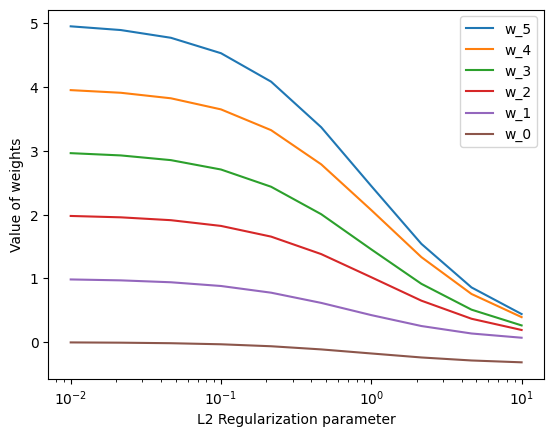

In [70]:
w_estimate_L2 = np.array(w_estimate_L2) #creating an array from the list of weight values
for p in np.arange(val_D,-1,-1): #counter for each weight
  plt.semilogx(lmb2_vector,w_estimate_L2[:,p], label = "w_{}".format(p)) # l2 parameter vs weight
plt.xlabel("L2 Regularization parameter") #defining x-axis label
plt.ylabel("Value of weights") #defining y-axis label
plt.legend() #show the legend
plt.show() #show the plot

**Obervation**: <br>
Expectedly, with increasing L2 parameter, all the weights together approach 0 <br> We do not see sequential sparsification of weights

**Next Step** <br>
We increase L1 parameter, while keeping L2 = 0, and plot the weights

## Effect of lmb1 on variable elimination with uncorrelated columns


In [71]:
num_lmb1, runs = 20, 5 #number of testing points for l1 regularization and number of runs of experiment
lmb1_vector = np.logspace(-2,1, num = num_lmb1) # range of l1 parameter from 0.01 to 10
val_M = 5 #number of baseline features
val_D = 5 #number of extracted features
val_N = 1000 #sample size
gen_mat = np.eye(val_M,val_D) #generator identity matrix
random_seed = 10 #random see
X = gen_data_matrix(val_N,gen_mat, random_seed) #generating the data matrix
variance = 0.1 #fixing the variance
w = np.arange(val_D+1).reshape(-1,1) #setting weights to be 0:val_D+1
w[2] = -w[2] #one of the weights is negative
t = gen_target(X, w, variance) #generating the target vector
w_estimate_L1 = [] #initializing the weight vector

linreg_Q11 = myLinearRegression(verbose = False) #creating an instance of myLinearRegression class

for lmb1_index in tqdm(np.arange(num_lmb1), desc = "Iter on L1-regularization"): #counter for l1 regression parameter
  w_calculate = []
  for r in tqdm(np.arange(runs), desc = "Experiments on each iteration"): #counter for number of runs
    train_fraction = 0.8 #fraction of data to be fixed for training
    train, test = linreg_Q11.train_test_split(X, t, train_fraction, random_seed) #Split into training and test data

    linreg_Q11.fit(train['X'], train['target'], L1 = lmb1_vector[lmb1_index], L2 = 0) #fitting with training data
    #print("L1 value = {}, r = {}".format(lmb1_index,r))
    w_calculate.append(linreg_Q11.w) #append the weights
  w_estimate_L1.append(np.mean(w_calculate, axis=0)) #append the overall weight vector


Iter on L1-regularization:   0%|          | 0/20 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

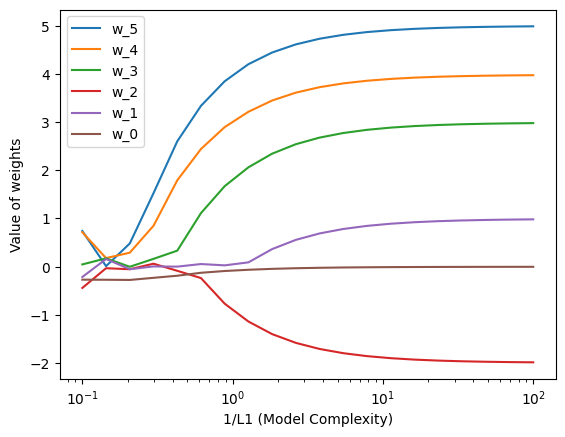

In [72]:
w_estimate_L1 = np.array(w_estimate_L1) #creating an array from the list of weight values
for p in np.arange(val_D, -1, -1): #counter for each weight
  plt.semilogx(1/lmb1_vector,w_estimate_L1[:,p],label = "w_{}".format(p)) # l1 parameter vs weight
plt.legend() #show the legend
plt.xlabel("1/L1 (Model Complexity)") #defining x-axis label
plt.ylabel("Value of weights") #defining y-axis label
plt.show() #show the plot

**Observation**: <br>
1. For small values of L1, w_estimate matches w, which was <br>
used to get the target vector. This serves as an indirect validation <br> of the model
2. For higher values of L1, W1 goes to 0, followed by W2, W3, W4 etc. They do so sequentially <br>
This shows the sparsification of weights. Theoretically, this happens because <br> the contour of MSE loss is tangential to contour of L1 regularization loss at the axis of weights in the weight-space. <br>

For very higher L1, some weights <br> show an increase in value but other weights become close to 0
<br>
<br>
**Next Step**: <br>
Introducing correlations to the columns and increasing L1

## Effect of lmb1 on variable elimination with correlated columns

In [74]:
num_lmb1, runs = 20, 5 #fixing the number of testing points for l1 regularization, number of runs of each experiment
lmb1_vector = np.logspace(-2,1, num = num_lmb1) #range of l1 regularization parameter between 0.01 and 10
val_M = 5 #number of baseline features
val_D = 5 #number of extracted features
val_N = 1000 #sample size
gen_mat = np.eye(val_M,val_D) #identity generator matrix
gen_mat[2,1], gen_mat[1,2] = 1, 1 #generating a symmetric correlation matrix
gen_mat[3,4], gen_mat[4,3] = 1, 1 #introducing negative correlations
random_seed = 10 #random seed
X = gen_data_matrix(val_N,gen_mat, random_seed) #generating the data matrix
variance = 0.1 #setting the variance
w = np.arange(val_D+1).reshape(-1,1) # weight vector is set to 0:val_D+1
w[2] = -w[2] #one of the weights is negative
t = gen_target(X, w, variance) #generating the target vector
w_estimate_corr = [] #initializing the weight vector
linreg_Q11b = myLinearRegression(verbose = False) #creating an instance of myLinearRegression class

for lmb1_index in tqdm(np.arange(num_lmb1), desc = "Iter on L1-regularization"): #counter for l1 regularization paraeter
  w_calculate = []
  for r in tqdm(np.arange(runs), desc = "Experiments on each iteration"): #counter for number of runs of an experiment
    train_fraction = 0.8 #fraction of training data
    train, test = linreg_Q11b.train_test_split(X, t, train_fraction, random_seed) #Split into training and test data

    linreg_Q11b.fit(train['X'], train['target'], L1 = lmb1_vector[lmb1_index], L2 = 0)   #fitting with training data
    #print("L1 value = {}, r = {}".format(lmb1_index,r))
    w_calculate.append(linreg_Q11b.w) #append the weights vector
  w_estimate_corr.append(np.mean(w_calculate, axis = 0)) #append the overall weight vector

Iter on L1-regularization:   0%|          | 0/20 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

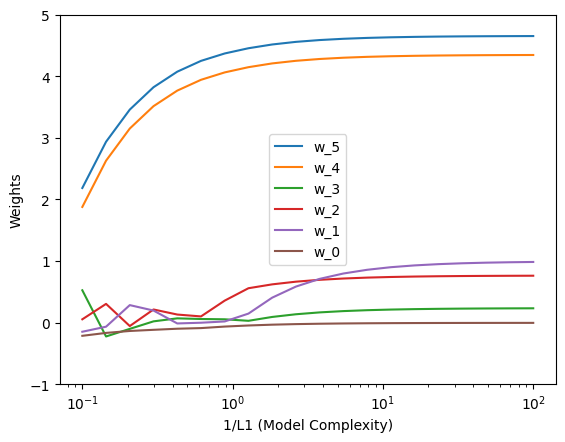

In [75]:
w_estimate_corr = np.array(w_estimate_corr) #converting the list to an numpy array
for p in np.arange(val_D,-1,-1): #counter for each weight
  plt.semilogx(1/lmb1_vector,w_estimate_corr[:,p], label = "w_{}".format(p)) #pltting lmb1_vector vs each weight
plt.xlabel("1/L1 (Model Complexity)") #defining the x-axis label
plt.ylabel("Weights") #defining y-axis label
plt.ylim(-1,5) #defining the limits on y-axis
plt.legend() #show the legend
plt.show() #show the plot

**Observation**: <br>
In our experiment, var2 is correlated to var3 while var4 is correlated to var5. L1 regularization sends w3, arbitrarily, to 0. For increasing L1, w4 and w5 have values that are close to each other <br>


**Next Step**: <br>
Let's now check elastic nets <br>


## Effect of lmb1 on grouping of variables in elastic nets

In [76]:
num_lmb1, runs = 20, 5 # fixing the number of points for l1 regularization, and number of runs of each experiment
lmb1_vector = np.logspace(-2,1, num = num_lmb1) #l1 regularization parameter will vary between 0.01 and 10
val_M = 5 #number of baseline features
val_D = 5 #number of extracted features
val_N = 1000 #sample size
gen_mat = np.eye(val_M,val_D) #generator matrix
gen_mat[2,1], gen_mat[1,2] = 1, 1 #generating a symmetric correlation matrix
gen_mat[3,4], gen_mat[4,3] = 1, 1 #introducing negative correlations
random_seed = 10 #random see
X = gen_data_matrix(val_N,gen_mat, random_seed) #generating the data matrix
variance = 0.1 #fixing the variance
w = np.arange(val_D+1).reshape(-1,1) #fixing the weights to be from 0 to val_D+1
t = gen_target(X, w, variance) #generating the target vector
w_estimate_corr_elastic = [] #initializing the weight vector

linreg_Q12 = myLinearRegression(verbose = False) #creating an instance of myLinearRegression class

for lmb1_index in tqdm(np.arange(num_lmb1), desc = "Iter on L1-regularization"): #counter for l1 regularization parameter
  w_estimate = [] #initializing w_estimate
  for r in tqdm(np.arange(runs), desc = "Experiments on each iteration"): # counter for number of runs
    train_fraction = 0.8 #fraction of data used for training
    train, test = linreg_Q12.train_test_split(X, t, train_fraction, random_seed) #Split into training and test data

    linreg_Q12.fit(train['X'], train['target'], L1 = lmb1_vector[lmb1_index], L2 = 1)    #Training with test data
    #print("L1 value = {}, r = {}".format(lmb1_index,r)) #Print L1 and r value
    w_estimate.append(linreg_Q12.w) #append w_estimate value
  w_estimate_corr_elastic.append(np.mean(w_estimate,axis=0)) #append overall w_estimate vector with mean from each experiment

Iter on L1-regularization:   0%|          | 0/20 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments on each iteration:   0%|          | 0/5 [00:00<?, ?it/s]

(-1.0, 5.0)

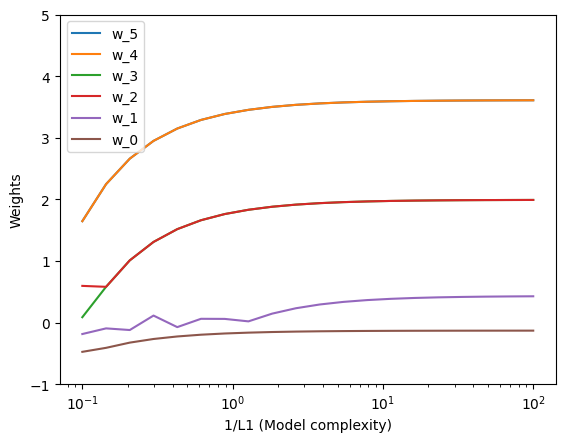

In [77]:
w_estimate_corr_elastic = np.array(w_estimate_corr_elastic) #converting the list to a numpy array
for p in np.arange(val_D, -1, -1): #
  plt.semilogx(1/lmb1_vector,w_estimate_corr_elastic[:,p], label = "w_{}".format(p))
plt.xlabel("1/L1 (Model complexity)")
plt.ylabel("Weights")
plt.legend()
plt.ylim(-1,5)

**Observation**: <br>
W2 and W3 have the same weights while W4 and W5 have the same weights. <br>
This shows the grouping of weights for correlated variables in elastic net <br>

**Next Step**: <br>
Q13

#Classification

## Classification vector generation <br>
$y = \frac{1}{1 + e^{-h_i}}$ <br>
<br>
$h_i = X\times w$

$T = H(y + noise - threshold)$, where H: heaviside function and threshold = 0.5

In [78]:
def gen_target_classification(X, w, variance): #generate the target vector
  #X: data matrix
  #w: weights
  #variance: variance controls the overlap in binary class
  X_with1 = np.column_stack((np.ones(len(X)),X)) #adding a column of 1's at the beginning. [11]
  h_i = np.matmul(X_with1,w) #h_i vector = W^T*X + b
  y_i = 1/(1 + np.exp(-h_i)) #sigmoid function
  #pdb.set_trace()
  mean = 0 #This ensures that error is introduced on both sides
  noise = np.random.normal(mean, np.sqrt(variance), (len(X),1)) #generating the noise with variance

  return np.heaviside(y_i + noise - 0.5, 0) # y_i + noise - 0.5 > 0 will be set to 1 and <= 0 will be set to 0 using the heaviside function


## Defining the class myLogRegression
An instance of the class has the following methods
1. calculate analytical solution for linear regression
2. train_test_split
3. calculate F1score
4. calculate misclassification error
5. gradient descent (fit)
6. predict the output
7. calculate gradient with L1 and L2 regularization

**Cross-entropy** <br>
$$Loss = -\frac{∑_i^N (T_i\times log(y_i) + (1-T_i)× log(1 - y_i))}{N} + \lambda_2\times \frac{w^T\times w}{2} + \lambda_1\times |w|$$<br>
$\nabla Loss$ is identical in form to regression formulation

In [79]:
class myLogRegression: #class for Logistic Regression [3][4]
  def __init__(self, learning_rate = 0.5, max_iterations = 100000, verbose = True):
    self.learning_rate = learning_rate #fixing learning rate
    self.max_iterations = max_iterations #fixing maximum iterations
    self.verbose = verbose #to display progress bar on gradient descent
    #self.tolerance = tolerance

  @staticmethod
  def train_test_split(dataset, target, percent_train, random_seed): #static method of splitting the data
    #dataset = datamatrix to be split
    #target = target vector to be split
    #percent_train = fraction of data to be used for training
    #random_seed

    np.random.seed(random_seed) #setting random seed to ensure reproducibility, inspiration from chatGPT
    index = np.arange(len(target)) #index of each sample is created
    np.random.shuffle(index) #index is shuffled
    train = dict() #creating a dictionary for train
    test = dict() #dictionary for test data. inspiration: [7]
    X_shuffle = dataset[index] #datamatrix is shuffled
    target_shuffle = target[index] #according targetmatrix is shuffled
    rows_interest = int(percent_train*np.size(target))#extracting rows of interest [8]]

    train['X'], test['X'] = np.split(X_shuffle,[rows_interest])#assigning train and test data for X. Use of split: [9]
    train['target'], test['target'] = np.split(target_shuffle,[rows_interest])# assigning train and test data for target
    return train, test #return the dictionary of test and train

  @staticmethod #Does not need an instance of the class. Does not use self
  def cal_F1score(target, y_pred): #calculate F1score
    #target: target vector
    #y_pred: a vector of prediction to be tested

    decision_prediction = np.heaviside(y_pred - 0.5,0) #Generate predictions by considering h_i = 0.5 as the threshold. Threshold in terms of y_i = 0


    TN = ((target==0) & (decision_prediction==0)).sum() #inspiration [10]
    TP = ((target==1) & (decision_prediction==1)).sum() #assuming class1 to be positive and class0 to be negative
    FN = ((target==1) & (decision_prediction==0)).sum() #inspiration [10]
    FP = ((target==0) & (decision_prediction==1)).sum() #inspiration [10]
    precision_score = TP/(TP + FP) #confidence of predicting the positive class
    recall_score = TP/(TP + FN) #calculate recall
    return (2*precision_score*recall_score)/(precision_score + recall_score) #return F1score

  @staticmethod #Does not need an instance of the class. Does not use self
  def cal_missclass(target, y_pred): #calculate misclassification error
    #target: target vector
    #y_pred: any vector of prediction for comparison
    decision_prediction = np.heaviside(y_pred - 0.5,0) #Generate predictions by considering h_i = 0.5 as the threshold. Threshold in terms of y_i = 0

    return np.sum(target!=decision_prediction)/len(target) #return the fraction of results that are misclassified



  def predict_y(self, X): #predict the probability of a class
    #X: data matrix
    X_with1 = np.column_stack((np.ones(len(X)),X)) #inspiration from [11]
    h_i = np.matmul(X_with1,self.w) #W^TX+b
    return 1/(1 + np.exp(-h_i)) #Sigmoid function


  #def cal_logloss(self, y_pred): #https://github.com/heena-sharma-sys/Machine-Learning/blob/main/Blog/LogisticRegressionFromScratch.ipynb
    #pdb.set_trace()
    #return -np.sum(np.log(y_pred[self.t==1]))/len(self.t) - np.sum(np.log(1-y_pred[self.t==0]))/len(self.t)


  def fit(self, X, target, L1, L2): #fit using gradient descent
    #X: data matrix
    #target: target vector
    #L1: L1 regularization parameter
    #L2: L2 regularization parameter
    w_old = np.random.random((len(X[0])+1,1)) #using an random value for initial point
    self.X = X #initialize data set
    self.target = target #initialize target vector
    self.L1 = L1 #initialize L1 parameter
    self.L2 = L2 #initialize L2 parameter

    counter = tqdm(range(self.max_iterations), desc = "Grad-Descent") if self.verbose else range(self.max_iterations) #print progressbar based on verbose
    for count in counter:
      w_new = w_old - self.learning_rate*self.cal_gradient_L1L2(w_old) #updating weights
      w_old = w_new # preparing for the next loop
    self.w = w_old #estimate weight is stored as a class variable to be used inside the class
    #count = 0 #setting initial counter to 0
    #while count < self.max_iterations: #Loop is terminated with count is equal to or greater than maxiter
    #  w_new = w_old - self.learning_rate*self.cal_gradient_L1L2(w_old) #Update of w in the opposite direction of gradient
    #  w_old = w_new #Otherwise w_old is updated and the loop continues
    #  count+=1 #Count increment
    #self.w = w_old #returning w at when either termination condition is reached

  def cal_gradient_L1L2(self, w_input): #calculate gradient using L1 and L2 regularization
    #w_input: weigths
    #self.X = data matrix
    #self.target = target vector
    X_with1 = np.column_stack((np.ones(np.size(self.target)),self.X)) #[11]
    h_i = np.matmul(X_with1,w_input) #W^TX+b
    y_input = 1/(1 + np.exp(-h_i)) #calculating probability of sample being in a class

    if self.L1 !=0 : #check if L1 is equal to 0
      L1_term = 0.5*self.L1*np.vstack([[0],np.sign(w_input[1:])]) #if not, calculate L1 term of gradient. Exclude bias term
    else:
      L1_term = 0 #else set L1_term to 0

    if self.L2 !=0 : #check if L2 is equal to 0
      L2_term =  self.L2*np.vstack([[0],w_input[1:]]) #If not, calculate its gradient term. Exclude bias term
    else:
      L2_term = 0 #else set L2_term to 0


    return -np.matmul(X_with1.T, (self.target-y_input)) + L1_term + L2_term #return the total gradient term


### Testing gradient descent with variance equal to 0

In [80]:
samples_N = 1000 #fixing the sample size
val_D = 2 #testing with 2-D dataset
M = 2 #number of original features
gen_mat = np.eye(M,val_D) # generator matrix
w = [[1], [5], [6]] #fixing the weights
variance = 0 #proportion of 0 and 1 would remain the same but the error would increase
X = gen_data_matrix(samples_N,gen_mat, random_seed = 10) #generating the data matrix
t = gen_target_classification(X, w, variance) #generating the target vector

logreg = myLogRegression() #creating an instance of myLogisticRegression class
logreg.fit(X,t, L1 = 0, L2 = 0) #fitting to data matrix


Grad-Descent:   0%|          | 0/100000 [00:00<?, ?it/s]

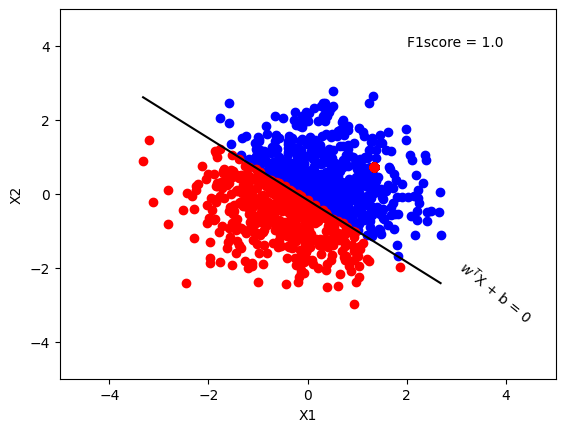

In [81]:
class1_index = np.where(t==1) #extracting indices where class = 1
class0_index = np.where(t==0) #extracting indices where class = 0
plt.scatter(X[class1_index,0], X[class1_index,1], color = "blue", label = "Class 1") #Generating a scatter plot of class1, [13]
plt.scatter(X[class0_index,0], X[class0_index,1], color = "red", label = "Class 0") #Generating a scatter plot of class2, [13]
plt.xlabel("X1") #defining the x-axis label
plt.ylabel("X2") #defining the y-axis label
xx = np.linspace(np.min(X[:,0]), np.max(X[:,0])) #[14]
yy = -logreg.w[0]/logreg.w[2] -(logreg.w[1]/logreg.w[2])*xx #Linear Decision boundary is at W1X1 + W2X2 + b = 0, where X2 = -b/W2 - (W1/W2)*X1

plt.plot(xx,yy, color = "black") #plotting the decision boundary
test_y = logreg.predict_y(X) #get the probabilities of class labels
F1score = logreg.cal_F1score(t, test_y) #Calculating the F1score to the plot
plt.text(2,4,"F1score = {}".format(F1score)) #print F1score on the plot
plt.text(3,-3.5, "$w^T$X + b = 0", rotation = -int(np.degrees(np.arctan(logreg.w[1]/logreg.w[2])))) #[15]

plt.xlim([-5, 5]) #defining the x-axis limit
plt.ylim([-5, 5]) #defining the y-axis limit
plt.show() #show the plot

**Observation**: <br>
1. With variance = 0, the two classes do not have an overlap. <br>
2. The logistic regression model gets an F1score of 1. <br>
*note*: I have not figured out why I have a single red dot on the blue side

**Next Step** <br>
I increase the variance to test if there is an overlap in the data and <br> calculate the corresponding F1score

### Testing with a variance not equal to 0

In [82]:
samples_N = 1000 #fixing the sample size
val_D = 2 #number of extracted features
M = 2 #number of original features
gen_mat = np.eye(M,val_D) #generator matrix
w = [[1], [5], [6]] #fixing the weights
variance = 0.1 #proportion of 0 and 1 would remain the same but the error would increase
X = gen_data_matrix(samples_N,gen_mat, random_seed = 10) #generating data matrix
t = gen_target_classification(X, w, variance) #generating target vector
logregb = myLogRegression() #creating an insatance of myLogRegression class
logregb.fit(X, t, L1=0, L2=0) #fitting to data


Grad-Descent:   0%|          | 0/100000 [00:00<?, ?it/s]

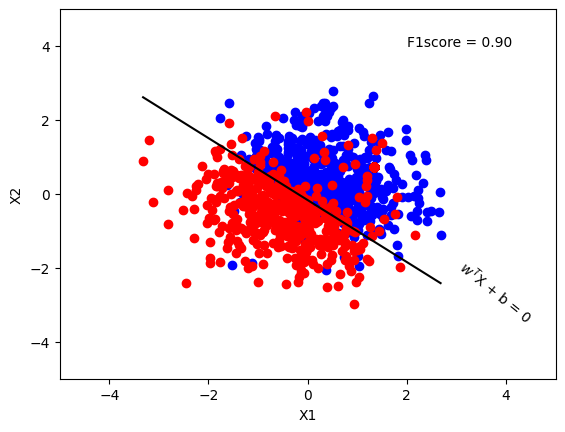

In [83]:
class1_index = np.where(t==1) #identifying indices with class1
class0_index = np.where(t==0) #identifying indices with class0

plt.scatter(X[class1_index,0], X[class1_index,1], color = "blue", label = "Class 1") #creating a scatter plot for class1, [13]
plt.scatter(X[class0_index,0], X[class0_index,1], color = "red", label = "Class 0") #creating a scatter plot for class0, [13]
plt.xlabel("X1") #define x-axis label
plt.ylabel("X2") #define y-axis label
xx = np.linspace(np.min(X[:,0]), np.max(X[:,0])) #generating range of xx, [14]
yy = -logreg.w[0]/logreg.w[2] -(logreg.w[1]/logreg.w[2])*xx #Linear Decision boundary is at W1X1 + W2X2 + b = 0, where X2 = -b/W2 - (W1/W2)*X1

plt.plot(xx,yy, color = "black") #plot decision boundary
plt.xlim([-5, 5]) #define x-axis limits
plt.ylim([-5, 5]) #define y-axis limits
plt.text(3,-3.5, "$w^T$X + b = 0", rotation = -int(np.degrees(np.arctan(logreg.w[1]/logreg.w[2])))) #show the equation for boundary, [15]

test_y = logreg.predict_y(X) #get probability of class labels
F1score = logreg.cal_F1score(t, test_y) #Add F1score to the figure
plt.text(2,4,"F1score = {:.2f}".format(F1score)) #show the F1score
plt.show() #show the plot

**Observation**: <br>
1. Now, with variance not equal to 0, we see an overlap in the classes <br>
2. The F1score of the linear model has reduced. <br>
Theoretically, Logistic regression must be overfitting this dataset and the <br> error introduced is due to the inherent variance in the data <br>
and not because of a failure in logistic regression <br>

**Next Step**: <br>
To prevent Logistic regression from overfitting the training set I will <br> introduce L2 regularization <br>
I will also check the effect of sample size and L2 parameter <br> on the F1score

## Examining the impact of N and λ2 on the classification error for logistic regression using gradient descent

In [85]:
num_N, num_lmb2, runs = 10,10,5 #number of sample sizes, number of L2 parameters, number of experiments
N_vector = np.logspace(1.5,3, num = num_N) #vector of samples sizes in the range [10 1000]
lmb2_vector = np.logspace(-3,1, num = num_lmb2) #vector of L2 parameter in the range [0.001 10]
val_M = 5 #number of original features
val_D = 5 #number of extracted features
gen_mat = np.eye(val_M,val_D) #generator matrix
error_N_lmb2_test = np.empty((num_N,num_lmb2)) #initializing test error
error_N_lmb2_train = np.empty((num_N,num_lmb2)) #initializing training error

logreg_Q15 = myLogRegression(verbose = False) #creating an instance of myLogisticRegression class

for N_index in tqdm(np.arange(num_N), desc = "Iter on Sample size"): #counter for sample size
  for l_index in tqdm(np.arange(num_lmb2), desc = "Iter on L2-regularization"): #counter for L2 parameter
    error_test = [] #initialize test error
    error_train = [] #initialize train error
    for r in np.arange(runs): #counter for number of experiments
      random_seed = np.random.randint(0,10) # random_seed
      val_N = int(N_vector[N_index]) #sample size
      X = gen_data_matrix(val_N,gen_mat, random_seed) #generate data matrix
      variance = 0.1 #fixing the variance
      w = np.arange(val_D+1).reshape(-1,1) # fixing the weights
      t = gen_target_classification(X, w, variance) #generating the target vector
      #Split into training and test data
      train_fraction = 0.8 #fraction of data used for training
      train, test = logreg_Q15.train_test_split(X, t, train_fraction, random_seed) #splitting the data to train and test set

      logreg_Q15.fit(train['X'], train['target'], L1 = 0, L2 = lmb2_vector[l_index]) #fitting the model to training data

      y_test = logreg_Q15.predict_y(test['X']) #predict labels of test data
      y_train = logreg_Q15.predict_y(train['X']) #predict labels of train data

      error_test.append(logreg_Q15.cal_missclass(test['target'], y_test)) #append test error
      error_train.append(logreg_Q15.cal_missclass(train['target'], y_train)) #append train error
      #print("N index = {}, L2 index = {}, r val = {}".format(N_index,l_index,r)) #print N_index, L2_index, and r_index
    error_N_lmb2_test[N_index,l_index] = np.mean(error_test) #calculate mean of test error over number of experiments
    error_N_lmb2_train[N_index,l_index] = np.mean(error_train) #calculate mean of train error over number of experiments


Iter on Sample size:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2-regularization:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2-regularization:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2-regularization:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2-regularization:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2-regularization:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2-regularization:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2-regularization:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2-regularization:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2-regularization:   0%|          | 0/10 [00:00<?, ?it/s]

Iter on L2-regularization:   0%|          | 0/10 [00:00<?, ?it/s]

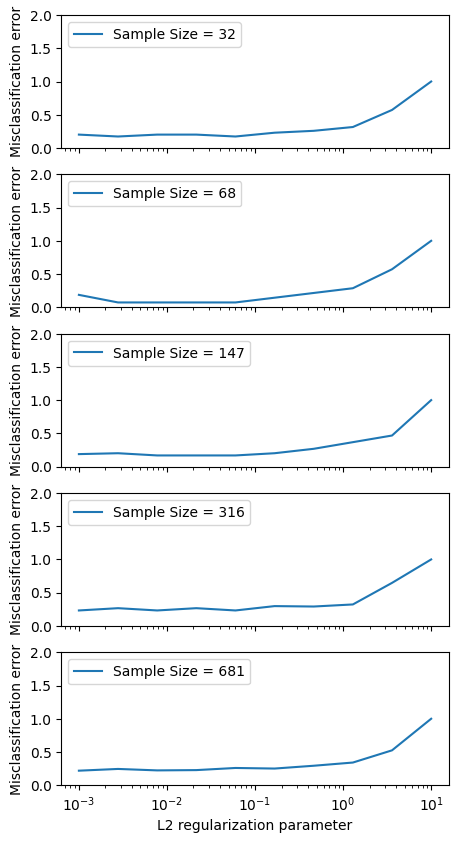

In [86]:
fig, ax = plt.subplots(5,1, figsize = (5,10), sharex = True) #defining the subplot axes and fig
for count, p in enumerate(np.arange(0,num_N, step=2)): #counter on sample size
  ax[count].semilogx(lmb2_vector, error_N_lmb2_test[p], label = "Sample Size = {:.0f}".format(N_vector[p])) #plot L2 vs test error
  ax[count].legend(loc = "upper left") # show legend
  ax[count].set_ylim(0,2) # set yaxis limits
  ax[count].set_ylabel("Misclassification error") # define y-axis label
ax[count].set_xlabel("L2 regularization parameter") #define x-axis label for the last panel

plt.show() #show the plot

**Observation**: <br>
For small sample size, there is overfitting of training set at L2 ~ 0.001 and underfitting of both training and test set at L2>1. This gives a minima on NRMSE with L2 parameter <br>
As sample sizes increase, the overfitting of training set at small L2 values is prevented since there is more data for the model to learn from. However, at higher L2 values <br> there is underfitting of the model to the training and test set leading to higher test errors <br>
<br>
<br>
Also, for lower sample sizes, underfitting of training and test set begins for lower values of L2.





## Sources of inspiration

1. https://stackoverflow.com/questions/13539968/how-can-i-find-the-dimensions-of-a-matrix-in-python

2. https://numpy.org/doc/stable/reference/generated/numpy.matmul.html#numpy.matmul

3. https://github.com/heena-sharma-sys/Machine-Learning/blob/main/Blog/LogisticRegressionFromScratch.ipynb

4. https://github.com/MadhumithaKannan/linear-regression-using-only-numpy

5. https://numpy.org/doc/stable/reference/generated/numpy.linalg.multi_dot.html

6. ChatGPT, https://chat.openai.com/

7. https://www.geeksforgeeks.org/g-fact-41-multiple-return-values-in-python/

8. https://www.geeksforgeeks.org/how-to-split-data-into-training-and-testing-in-python-without-sklearn/

9. https://numpy.org/doc/stable/reference/generated/numpy.split.html

10. https://medium.com/@Suraj_Yadav/compute-performance-metrics-from-scratch-53025140fe1d

11. https://stackoverflow.com/questions/32827269/adding-columns-to-matrix-in-python

12. https://realpython.com/python-enumerate/

13. https://aleksandarhaber.com/scatter-plots-for-classification-problems-in-python-and-scikit-learn/

14. https://stackoverflow.com/questions/22294241/plotting-a-decision-boundary-separating-2-classes-using-matplotlibs-pyplot

15. https://stackoverflow.com/questions/41153317/add-text-next-to-vertical-line-in-matplotlib

16. https://inria.github.io/scikit-learn-mooc/overfit/learning_validation_curves_slides.html


[1]: https://stackoverflow.com/questions/13539968/how-can-i-find-the-dimensions-of-a-matrix-in-python


[1]: https://stackoverflow.com/questions/13539968/how-can-i-find-the-dimensions-of-a-matrix-in-python